# Weather Model Training v4.0 - Date-Based Seasonality Model
    
Implementasi **Date-Based Seasonality Model** sesuai `training_guide_v4.md`.
    
## Karakteristik v4.0:
*   **Input:** HANYA komponen waktu (`day`, `month`, `year`, `hour`).
*   **Tanpa Sensor Input:** Tidak membutuhkan data suhu/kelembaban masa lalu untuk prediksi.
*   **Strategi:** Direct Mapping (Tanggal -> Cuaca), cocok untuk forecasting jangka panjang.


## 1. Persiapan Lingkungan

In [279]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
import os
warnings.filterwarnings('ignore')

from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.svm import SVR

try:
    from xgboost import XGBRegressor, XGBClassifier
    XGBOOST_AVAILABLE = True
except ImportError:
    XGBOOST_AVAILABLE = False

import joblib
print(f"Libraries loaded | XGBoost: {XGBOOST_AVAILABLE}")

Libraries loaded | XGBoost: True


## 2. Load Data

In [280]:
DATA_PATH = '../data/historical_data_2000_2024.csv'
df = pd.read_csv(DATA_PATH)
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.sort_values('timestamp').reset_index(drop=True)
print(f"Dataset: {len(df):,} rows x {len(df.columns)} cols")
print(f"Range: {df['timestamp'].min()} to {df['timestamp'].max()}")
df.head()

Dataset: 227,304 rows x 23 cols
Range: 2000-01-01 00:00:00 to 2025-12-05 23:00:00


,id,timestamp,hour,day,month,year,temp,humidity,windspeed,sealevelpressure,...,surface_pressure,weather_code,conditions,temp_max_daily,temp_min_daily,weather_code_daily,temp_mean_daily,humidity_avg_daily,pressure_avg_daily,windspeed_avg_daily
0,0,2000-01-01 00:00:00,0,1,1,2000,21.8,98,4.0,1008.4,...,984.5,3,Overcast,27.5,20.8,53,24.1,91,1007.3,6.3
1,1,2000-01-01 01:00:00,1,1,1,2000,21.4,99,4.0,1007.9,...,983.9,3,Overcast,27.5,20.8,53,24.1,91,1007.3,6.3
2,2,2000-01-01 02:00:00,2,1,1,2000,21.4,98,3.2,1007.4,...,983.4,3,Overcast,27.5,20.8,53,24.1,91,1007.3,6.3
3,3,2000-01-01 03:00:00,3,1,1,2000,21.2,99,4.6,1007.0,...,983.0,3,Overcast,27.5,20.8,53,24.1,91,1007.3,6.3
4,4,2000-01-01 04:00:00,4,1,1,2000,21.0,99,3.6,1006.9,...,982.9,3,Overcast,27.5,20.8,53,24.1,91,1007.3,6.3


## 3. EDA (Exploratory Data Analysis)

### 3.1 Statistik Deskriptif

In [281]:
df.describe()

,id,timestamp,hour,day,month,year,temp,humidity,windspeed,sealevelpressure,...,apparent_temperature,surface_pressure,weather_code,temp_max_daily,temp_min_daily,weather_code_daily,temp_mean_daily,humidity_avg_daily,pressure_avg_daily,windspeed_avg_daily
count,227304.000000,227304,227304.000000,227304.000000,227304.000000,227304.000000,227304.000000,227304.000000,227304.000000,227304.000000,...,227304.000000,227304.000000,227304.000000,227304.000000,227304.000000,227304.000000,227304.000000,227304.000000,227304.000000,227304.000000
mean,113651.500000,2012-12-18 11:30:00,11.500000,15.722733,6.507655,2012.465315,25.537435,79.351679,6.158908,1010.092567,...,29.415371,986.395679,17.317702,29.926291,22.183349,46.263858,25.528656,79.358568,1010.092334,6.160775
min,0.000000,2000-01-01 00:00:00,0.000000,1.000000,1.000000,2000.000000,17.000000,16.000000,0.000000,1002.200000,...,17.200000,978.700000,0.000000,23.300000,17.000000,0.000000,22.400000,40.000000,1004.600000,1.700000
25%,56825.750000,2006-06-25 17:45:00,5.750000,8.000000,4.000000,2006.000000,23.200000,71.000000,3.400000,1008.800000,...,27.100000,985.200000,2.000000,28.300000,21.500000,51.000000,24.500000,69.000000,1009.200000,4.300000
50%,113651.500000,2012-12-18 11:30:00,11.500000,16.000000,7.000000,2012.000000,25.000000,83.000000,5.200000,1010.200000,...,29.200000,986.400000,3.000000,29.500000,22.200000,55.000000,25.300000,84.000000,1010.200000,5.500000
75%,170477.250000,2019-06-13 05:15:00,17.250000,23.000000,9.000000,2019.000000,27.500000,93.000000,8.000000,1011.400000,...,31.500000,987.700000,51.000000,31.500000,23.000000,63.000000,26.500000,89.000000,1011.000000,7.200000
max,227303.000000,2025-12-05 23:00:00,23.000000,31.000000,12.000000,2025.000000,37.800000,100.000000,34.700000,1016.800000,...,40.500000,993.000000,65.000000,37.800000,25.400000,65.000000,30.400000,98.000000,1014.800000,26.900000
std,65617.157131,NaN,6.922202,8.802513,3.441529,7.482007,3.021772,16.929004,3.900788,1.867129,...,3.213625,1.793721,23.757623,2.317400,1.166040,23.501871,1.344515,11.826198,1.375177,2.657015


### 3.2 Distribusi Parameter Hourly

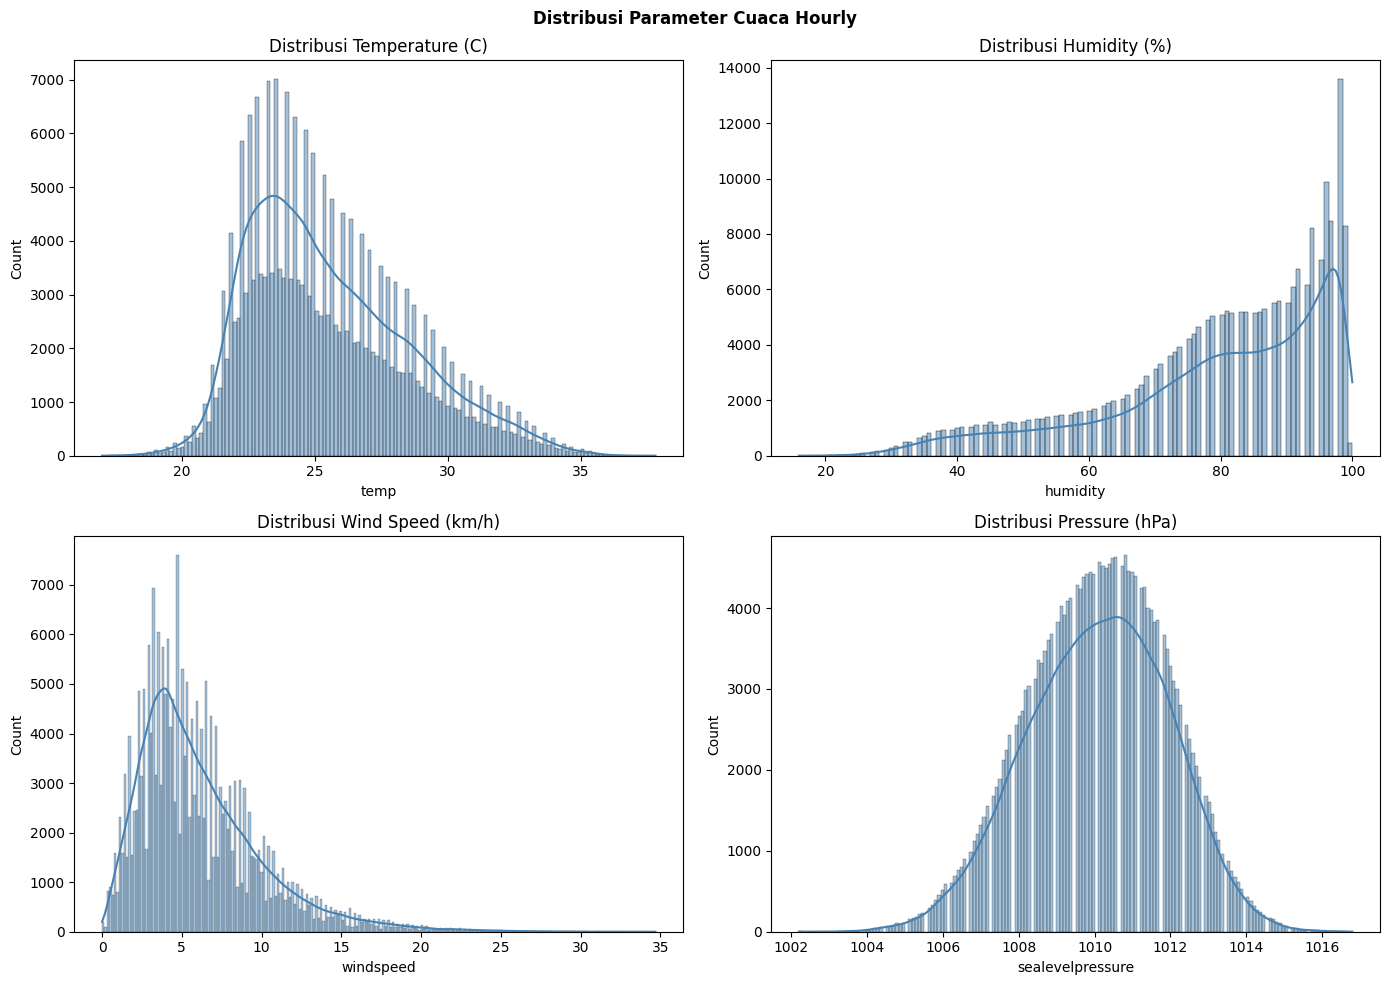

In [282]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
params = ['temp', 'humidity', 'windspeed', 'sealevelpressure']
titles = ['Temperature (C)', 'Humidity (%)', 'Wind Speed (km/h)', 'Pressure (hPa)']
for ax, param, title in zip(axes.flatten(), params, titles):
    sns.histplot(df[param], kde=True, ax=ax, color='steelblue')
    ax.set_title(f'Distribusi {title}')
plt.suptitle('Distribusi Parameter Cuaca Hourly', fontweight='bold')
plt.tight_layout()
plt.show()

### 3.3 Korelasi Heatmap

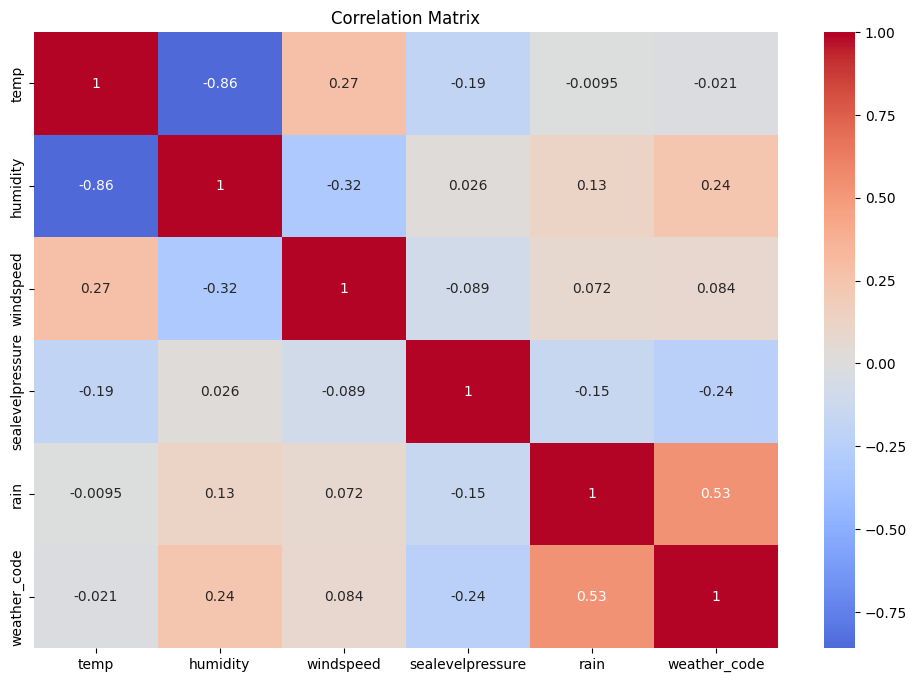

In [283]:
plt.figure(figsize=(12, 8))
cols = ['temp', 'humidity', 'windspeed', 'sealevelpressure', 'rain', 'weather_code']
sns.heatmap(df[cols].corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix')
plt.show()

### 3.4 Weather Code vs Rain

In [284]:
df.groupby('conditions')[['rain']].agg(['mean', 'count'])

rain       
                      mean  count
conditions                       
Clear             0.000000  23299
Overcast          0.000000  81996
Partially cloudy  0.000000  54988
Rain              0.374329  53313
Rain, Overcast    3.039079  13708

## 4. Feature Engineering

### 4.1 Label Encoding

In [285]:
df_hourly = df.copy()
le_conditions = LabelEncoder()
df_hourly['conditions_encoded'] = le_conditions.fit_transform(df_hourly['conditions'])
# If 'conditions_dominant' refers to the same 'conditions' column,
# use the already fitted encoder to transform, or assign the same encoded column.
# If 'conditions_dominant' is a different column, a separate encoder might be needed.
df_hourly['conditions_dominant_encoded'] = le_conditions.transform(df_hourly['conditions']) # Use transform instead of fit_transform
print("Label encoding done")
print("Label mapping for 'conditions':")
# Store the original labels for use in the confusion matrix
original_condition_labels = le_conditions.classes_
for i, label in enumerate(original_condition_labels):
    print(f"{label}: {i}")

Label encoding done
Label mapping for 'conditions':
Clear: 0
Overcast: 1
Partially cloudy: 2
Rain: 3
Rain, Overcast: 4


### 4.5 Preprocessing Data Daily

In [286]:
# Agregasi hourly ke daily
df_daily = df.groupby(['year', 'month', 'day']).agg({
    'temp': ['min', 'max', 'mean'],
    'humidity': 'mean',
    'windspeed': 'mean',
    'sealevelpressure': 'mean',
    'conditions': lambda x: x.mode()[0],
    'rain': 'sum'
}).reset_index()

df_daily.columns = ['year', 'month', 'day', 'temp_min', 'temp_max', 'temp_mean',
                    'humidity_avg', 'windspeed_avg', 'pressure_avg',
                    'conditions_dominant', 'rain_total']

le_conditions_daily = LabelEncoder()
df_daily['conditions_dominant_encoded'] = le_conditions_daily.fit_transform(df_daily['conditions_dominant'])
print(f"Daily: {len(df_daily):,} rows")

Daily: 9,471 rows


## 5. Model Training

### 5.1 Define Features & Targets

In [287]:
from sklearn.model_selection import train_test_split

hourly_feature_cols = ['day', 'month', 'year', 'hour']
daily_feature_cols = ['day', 'month', 'year']

# Target tetap sama
hourly_target_reg = ['temp', 'humidity', 'windspeed', 'sealevelpressure']
hourly_target_clf = 'conditions_encoded'

daily_target_reg = ['temp_min', 'temp_max', 'temp_mean', 'humidity_avg', 'windspeed_avg', 'pressure_avg']
daily_target_clf = 'conditions_dominant_encoded'


### 5.2 Data Split (HOURLY)

In [288]:
# Hourly Random Split
X_hourly_train, X_hourly_test, y_hourly_train_reg, y_hourly_test_reg = train_test_split(
    df_hourly[hourly_feature_cols], 
    df_hourly[hourly_target_reg], 
    test_size=0.2, 
    random_state=42
)
y_hourly_train_clf, y_hourly_test_clf = train_test_split(
    df_hourly[hourly_target_clf], test_size=0.2, random_state=42
)

print(f"Hourly Train: {len(X_hourly_train):,} | Test: {len(X_hourly_test):,}")

Hourly Train: 181,843 | Test: 45,461


### 5.3 Data Split (DAILY)

In [289]:
# Daily Random Split
X_daily_train, X_daily_test, y_daily_train_reg, y_daily_test_reg = train_test_split(
    df_daily[daily_feature_cols], 
    df_daily[daily_target_reg], 
    test_size=0.2, 
    random_state=42
)
y_daily_train_clf, y_daily_test_clf = train_test_split(
    df_daily[daily_target_clf], test_size=0.2, random_state=42
)

print(f"Daily Train: {len(X_daily_train):,} | Test: {len(X_daily_test):,}")

Daily Train: 7,576 | Test: 1,895


### 5.4 Define Model Regression & Classification

In [290]:
# Regression Models
regression_models = {
    'Linear Regression': LinearRegression(),
    'K-Neighbors Regressor': KNeighborsRegressor(n_neighbors=5, n_jobs=-1),
    'Decision Tree Regressor': DecisionTreeRegressor(random_state=42, max_depth=10),
    'Random Forest Regressor': RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
}
if XGBOOST_AVAILABLE:
    regression_models['XGBoost Regressor'] = XGBRegressor(n_estimators=100, random_state=42, n_jobs=-1, verbosity=0)

In [291]:
# Classification Models
classification_models = {
    'Logistic Regression Balanced': LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42, n_jobs=-1),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42, n_jobs=-1),
    'Decision Tree Classifier': DecisionTreeClassifier(random_state=42, max_depth=10),
    'Random Forest Classifier Balanced': RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42, n_jobs=-1),
    'Random Forest Classifier': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
}
if XGBOOST_AVAILABLE:
    classification_models['XGBoost Classifier'] = XGBClassifier(n_estimators=100, random_state=42, n_jobs=-1, verbosity=0)

### 5.4 Regression Models (HOURLY)

In [292]:
def evaluate_regression(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    return {'MSE': mse, 'RMSE': np.sqrt(mse), 'MAE': mean_absolute_error(y_true, y_pred), 'R2': r2_score(y_true, y_pred)}

reg_results = []
for name, model in regression_models.items():
    print(f"Training {name}...")
    model.fit(X_hourly_train, y_hourly_train_reg)
    y_pred = model.predict(X_hourly_test)
    metrics = evaluate_regression(y_hourly_test_reg, y_pred)
    metrics['Model'] = name
    reg_results.append(metrics)

df_hourly_reg = pd.DataFrame(reg_results).sort_values('R2', ascending=False)
display(df_hourly_reg[['Model', 'R2', 'RMSE', 'MAE']])
best_hourly_reg_name = df_hourly_reg.iloc[0]['Model']
print(f"Best Hourly Regression: {best_hourly_reg_name}")

Training Linear Regression...
Training K-Neighbors Regressor...
Training Decision Tree Regressor...
Training Random Forest Regressor...
Training XGBoost Regressor...


,Model,R2,RMSE,MAE
3,Random Forest Regressor,0.862516,2.523073,1.399859
1,K-Neighbors Regressor,0.792312,3.166402,1.840541
4,XGBoost Regressor,0.787547,3.201235,1.880795
2,Decision Tree Regressor,0.592962,4.372031,2.513255
0,Linear Regression,0.068664,8.447792,4.869676


Best Hourly Regression: Random Forest Regressor


### 5.5 Classification with Class Balancing (HOURLY)

In [293]:
clf_results = []
for name, model in classification_models.items():
    print(f"Training {name}...")
    model.fit(X_hourly_train, y_hourly_train_clf)
    y_pred = model.predict(X_hourly_test)
    clf_results.append({'Model': name, 'Accuracy': accuracy_score(y_hourly_test_clf, y_pred), 
                        'F1': f1_score(y_hourly_test_clf, y_pred, average='weighted', zero_division=0)})

df_hourly_clf = pd.DataFrame(clf_results).sort_values('Accuracy', ascending=False)
display(df_hourly_clf)
best_hourly_clf_name = df_hourly_clf.iloc[0]['Model']
print(f"Best Hourly Classification: {best_hourly_clf_name}")

Training Logistic Regression Balanced...


Training Logistic Regression...
Training Decision Tree Classifier...
Training Random Forest Classifier Balanced...
Training Random Forest Classifier...
Training XGBoost Classifier...


,Model,Accuracy,F1
4,Random Forest Classifier,0.546534,0.542962
3,Random Forest Classifier Balanced,0.542333,0.538539
5,XGBoost Classifier,0.519368,0.504996
2,Decision Tree Classifier,0.474209,0.447281
1,Logistic Regression,0.353006,0.243089
0,Logistic Regression Balanced,0.225644,0.243276


Best Hourly Classification: Random Forest Classifier


### 5.6 Regression Models (DAILY)

In [294]:
daily_reg_results = []
for name, model in regression_models.items():
    print(f"Training Daily {name}...")
    model.fit(X_daily_train, y_daily_train_reg)
    y_pred = model.predict(X_daily_test)
    metrics = evaluate_regression(y_daily_test_reg, y_pred)
    metrics['Model'] = name
    daily_reg_results.append(metrics)

df_daily_reg = pd.DataFrame(daily_reg_results).sort_values('R2', ascending=False)
display(df_daily_reg[['Model', 'R2', 'RMSE', 'MAE']])
best_daily_reg_name = df_daily_reg.iloc[0]['Model']
print(f"Best Daily Regression: {best_daily_reg_name}")

Training Daily Linear Regression...
Training Daily K-Neighbors Regressor...
Training Daily Decision Tree Regressor...
Training Daily Random Forest Regressor...
Training Daily XGBoost Regressor...


,Model,R2,RMSE,MAE
3,Random Forest Regressor,0.787586,1.723284,0.980264
4,XGBoost Regressor,0.706243,2.026056,1.167654
1,K-Neighbors Regressor,0.609780,2.466139,1.397181
2,Decision Tree Regressor,0.593257,2.430751,1.349481
0,Linear Regression,0.175554,4.713503,2.525896


Best Daily Regression: Random Forest Regressor


### 5.7 Classification (DAILY)

In [295]:
daily_clf_results = []
for name, model in classification_models.items():
    print(f"Training Daily {name}...")
    model.fit(X_daily_train, y_daily_train_clf)
    y_pred = model.predict(X_daily_test)
    daily_clf_results.append({'Model': name, 'Accuracy': accuracy_score(y_daily_test_clf, y_pred),
                              'F1': f1_score(y_daily_test_clf, y_pred, average='weighted', zero_division=0)})

df_daily_clf = pd.DataFrame(daily_clf_results).sort_values('Accuracy', ascending=False)
display(df_daily_clf)
best_daily_clf_name = df_daily_clf.iloc[0]['Model']
print(f"Best Daily Classification: {best_daily_clf_name}")

Training Daily Logistic Regression Balanced...
Training Daily Logistic Regression...
Training Daily Decision Tree Classifier...
Training Daily Random Forest Classifier Balanced...
Training Daily Random Forest Classifier...
Training Daily XGBoost Classifier...


,Model,Accuracy,F1
3,Random Forest Classifier Balanced,0.529815,0.526150
4,Random Forest Classifier,0.520844,0.516428
5,XGBoost Classifier,0.516623,0.507727
2,Decision Tree Classifier,0.474934,0.462346
1,Logistic Regression,0.467546,0.297911
0,Logistic Regression Balanced,0.207388,0.182091


Best Daily Classification: Random Forest Classifier Balanced


## 6. Analisis Kinerja Individual Parameter

### 6.1 Analisis Individual Regresi

#### 6.1.1 Hourly

In [296]:
# Train best models Regression (hourly)
# best_reg_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
for name, model in regression_models.items():
    if name == best_hourly_reg_name:
        best_hourly_reg_model = model

# Train best model (hourly)
best_hourly_reg_model.fit(X_hourly_train, y_hourly_train_reg)

# Per-parameter evaluation (hourly)
y_hourly_pred = best_hourly_reg_model.predict(X_hourly_test)
param_results = []
for i, param in enumerate(hourly_target_reg):
    mae = mean_absolute_error(y_hourly_test_reg.iloc[:, i], y_hourly_pred[:, i])
    rmse = np.sqrt(mean_squared_error(y_hourly_test_reg.iloc[:, i], y_hourly_pred[:, i]))
    r2 = r2_score(y_hourly_test_reg.iloc[:, i], y_hourly_pred[:, i])
    param_results.append({'Parameter': param, 'MAE': round(mae, 4), 'RMSE': round(rmse, 4), 'R2': round(r2, 4)})

print(f"\nBest Model hourly Regression: {best_hourly_reg_name}")
print("\nPer-parameter evaluation (hourly):")
display(pd.DataFrame(param_results))


Best Model hourly Regression: Random Forest Regressor

Per-parameter evaluation (hourly):


,Parameter,MAE,RMSE,R2
0,temp,0.4914,0.6932,0.9476
1,humidity,3.0345,4.4415,0.9315
2,windspeed,1.5910,2.2029,0.6861
3,sealevelpressure,0.4825,0.6347,0.8849


#### 6.1.2 Daily

In [297]:
# Train best models Regression (daily)
# best_daily_reg_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
for name, model in regression_models.items():
    if name == best_daily_reg_name:
        best_daily_reg_model = model

# Train best model (daily)
best_daily_reg_model.fit(X_daily_train, y_daily_train_reg)

# Per-parameter evaluation (daily)
y_daily_pred = best_daily_reg_model.predict(X_daily_test)
param_results = []
for i, param in enumerate(daily_target_reg):
    mae = mean_absolute_error(y_daily_test_reg.iloc[:, i], y_daily_pred[:, i])
    rmse = np.sqrt(mean_squared_error(y_daily_test_reg.iloc[:, i], y_daily_pred[:, i]))
    r2 = r2_score(y_daily_test_reg.iloc[:, i], y_daily_pred[:, i])
    param_results.append({'Parameter': param, 'MAE': round(mae, 4), 'RMSE': round(rmse, 4), 'R2': round(r2, 4)})

print(f"\nBest Model daily Regression: {best_daily_reg_name}")
print("\nPer-parameter evaluation (daily):")
display(pd.DataFrame(param_results))


Best Model daily Regression: Random Forest Regressor

Per-parameter evaluation (daily):


,Parameter,MAE,RMSE,R2
0,temp_min,0.5184,0.6855,0.6588
1,temp_max,0.6780,0.8960,0.8505
2,temp_mean,0.3661,0.4798,0.8731
3,humidity_avg,2.7167,3.6549,0.9046
4,windspeed_avg,1.1103,1.5996,0.6465
5,pressure_avg,0.4920,0.6311,0.7921


### 6.2 Analisis Individual Klasifikasi

#### 6.2.1 Hourly

In [298]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Train best models Classification
# best_hourly_clf_model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42, n_jobs=-1)

for name, model in classification_models.items():
    # if name == best_hourly_clf_name:
    if name == "Random Forest Classifier Balanced":
        best_hourly_clf_model = model
        best_hourly_clf_name = name

best_hourly_clf_model.fit(X_hourly_train, y_hourly_train_clf)

y_hourly_pred_clf = best_hourly_clf_model.predict(X_hourly_test)
y_hourly_pred_proba_clf = best_hourly_clf_model.predict_proba(X_hourly_test)

hourly_clf_accuracy = accuracy_score(y_hourly_test_clf, y_hourly_pred_clf)
hourly_clf_precision = precision_score(y_hourly_test_clf, y_hourly_pred_clf, average='weighted')
hourly_clf_recall = recall_score(y_hourly_test_clf, y_hourly_pred_clf, average='weighted')
hourly_clf_f1 = f1_score(y_hourly_test_clf, y_hourly_pred_clf, average='weighted')


In [299]:
print(f"=== HOURLY ===")
print(f"\nBest Model: {best_hourly_clf_name}")
print(f"\nAccuracy: {hourly_clf_accuracy:.4f}")
print(f"Precision (weighted): {hourly_clf_precision:.4f}")
print(f"Recall (weighted): {hourly_clf_recall:.4f}")
print(f"F1-Score (weighted): {hourly_clf_f1:.4f}")

print("\nReport:")
print(classification_report(y_hourly_test_clf, y_hourly_pred_clf, target_names=le_conditions.classes_))


=== HOURLY ===

Best Model: Random Forest Classifier Balanced

Accuracy: 0.5423
Precision (weighted): 0.5377
Recall (weighted): 0.5423
F1-Score (weighted): 0.5385

Report:
                  precision    recall  f1-score   support

           Clear       0.53      0.45      0.49      4681
        Overcast       0.59      0.65      0.62     16451
Partially cloudy       0.51      0.51      0.51     10939
            Rain       0.52      0.53      0.52     10593
  Rain, Overcast       0.40      0.27      0.32      2797

        accuracy                           0.54     45461
       macro avg       0.51      0.48      0.49     45461
    weighted avg       0.54      0.54      0.54     45461



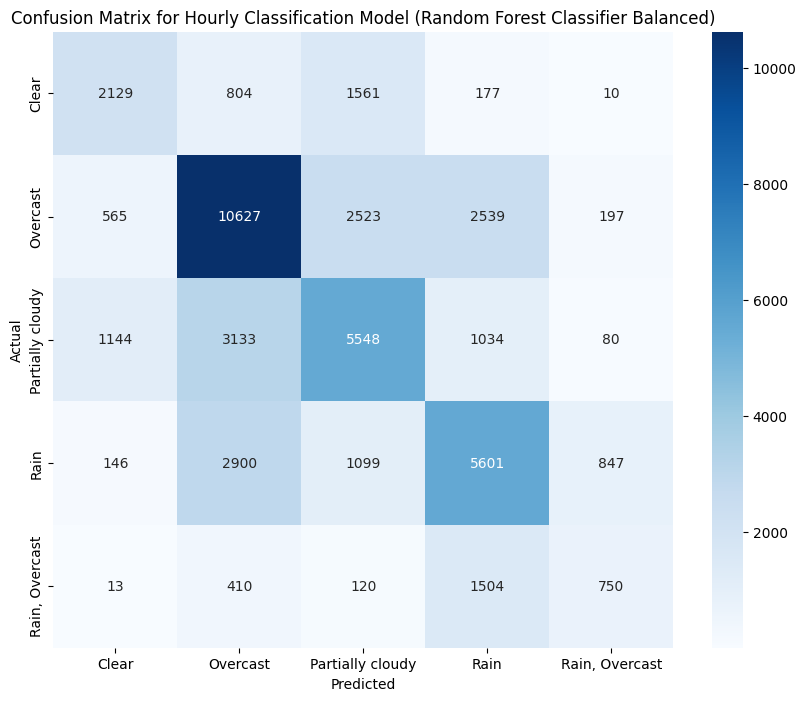

In [300]:
cm = confusion_matrix(y_hourly_test_clf, y_hourly_pred_clf)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le_conditions.classes_, yticklabels=le_conditions.classes_)
plt.title(f'Confusion Matrix for Hourly Classification Model ({best_hourly_clf_name})')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

#### 6.2.2 Daily

In [301]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Train best models Classification
# best_daily_clf_model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42, n_jobs=-1)
for name, model in classification_models.items():
    if name == best_daily_clf_name:
        best_daily_clf_model = model

best_daily_clf_model.fit(X_daily_train, y_daily_train_clf)

y_daily_pred_clf = best_daily_clf_model.predict(X_daily_test)
y_daily_pred_proba_clf = best_daily_clf_model.predict_proba(X_daily_test)

daily_clf_accuracy = accuracy_score(y_daily_test_clf, y_daily_pred_clf)
daily_clf_precision = precision_score(y_daily_test_clf, y_daily_pred_clf, average='weighted')
daily_clf_recall = recall_score(y_daily_test_clf, y_daily_pred_clf, average='weighted')
daily_clf_f1 = f1_score(y_daily_test_clf, y_daily_pred_clf, average='weighted')


In [302]:
print(f"=== DAILY ===")
print(f"\nBest Model: {best_daily_clf_name}")
print(f"\nAccuracy: {daily_clf_accuracy:.4f}")
print(f"Precision (weighted): {daily_clf_precision:.4f}")
print(f"Recall (weighted): {daily_clf_recall:.4f}")
print(f"F1-Score (weighted): {daily_clf_f1:.4f}")

print("\nReport:")
print(classification_report(y_daily_test_clf, y_daily_pred_clf, target_names=le_conditions.classes_))


=== DAILY ===

Best Model: Random Forest Classifier Balanced

Accuracy: 0.5298
Precision (weighted): 0.5259
Recall (weighted): 0.5298
F1-Score (weighted): 0.5261

Report:
                  precision    recall  f1-score   support

           Clear       0.43      0.32      0.37       168
        Overcast       0.59      0.63      0.61       886
Partially cloudy       0.44      0.48      0.46       454
            Rain       0.53      0.47      0.50       370
  Rain, Overcast       0.17      0.06      0.09        17

        accuracy                           0.53      1895
       macro avg       0.43      0.39      0.40      1895
    weighted avg       0.53      0.53      0.53      1895



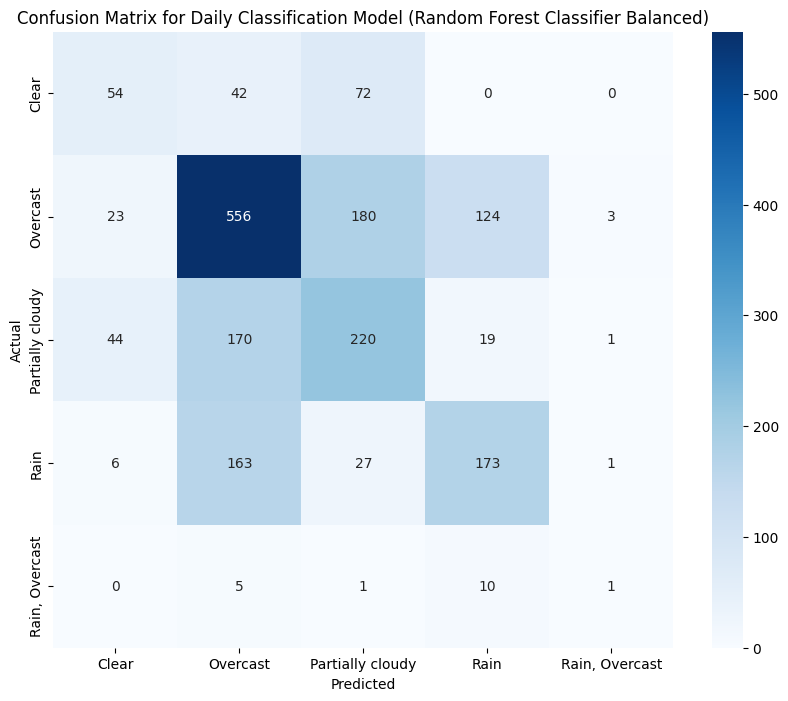

In [303]:
cm = confusion_matrix(y_daily_test_clf, y_daily_pred_clf)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le_conditions.classes_, yticklabels=le_conditions.classes_)
plt.title(f'Confusion Matrix for Daily Classification Model ({best_daily_clf_name})')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

### 6.2 Visualisasi Januari 2022 (Gap 2 Hari)

In [304]:
year = 2022
month = 1
month_map = {
    1: 'January', 2: 'February', 3: 'March', 4: 'April',
    5: 'May', 6: 'June', 7: 'July', 8: 'August',
    9: 'September', 10: 'October', 11: 'November', 12: 'December'
}

--- Regression Performance Evaluation (Daily Data) ---


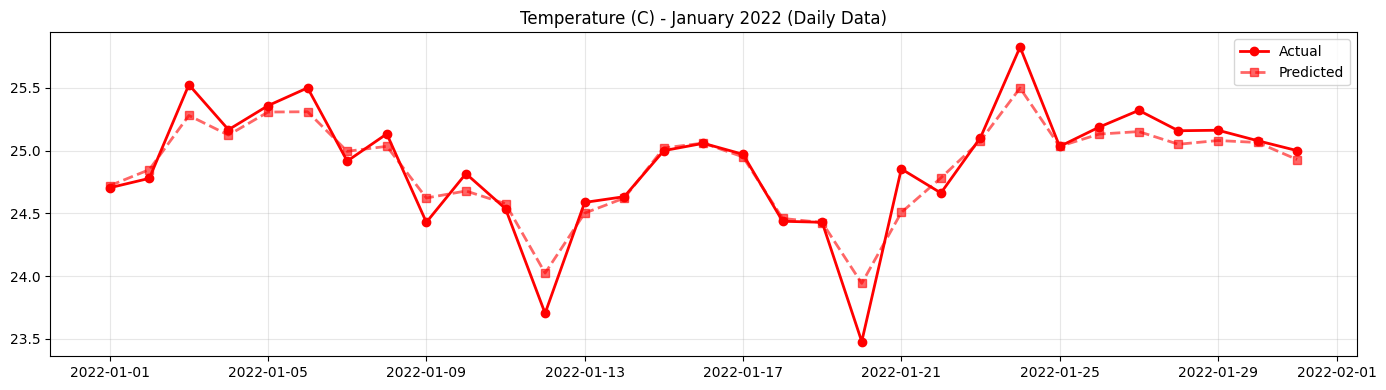


Temperature (C) Metrics:
  R-squared: 0.8852
  MAE: 0.1107
  MSE: 0.0259
  RMSE: 0.1610


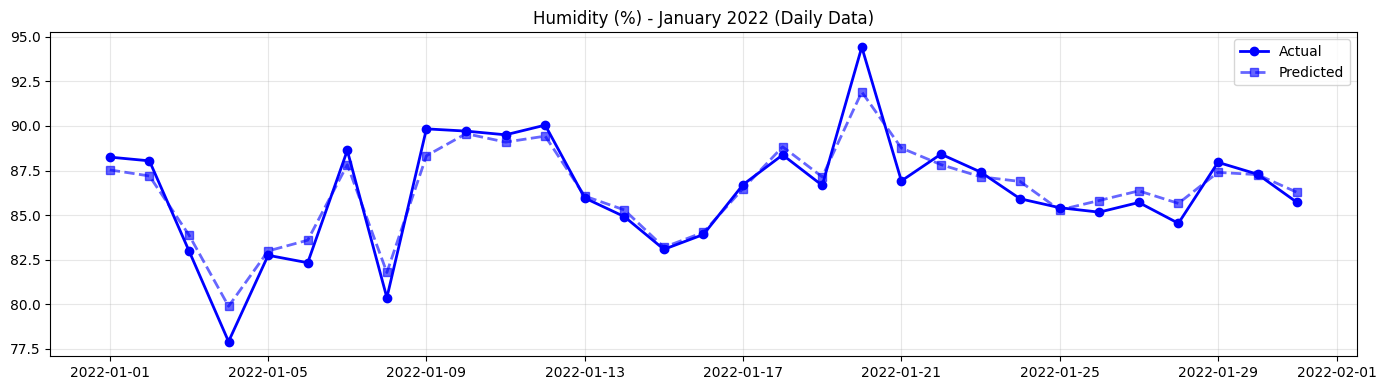


Humidity (%) Metrics:
  R-squared: 0.9110
  MAE: 0.7281
  MSE: 0.8887
  RMSE: 0.9427


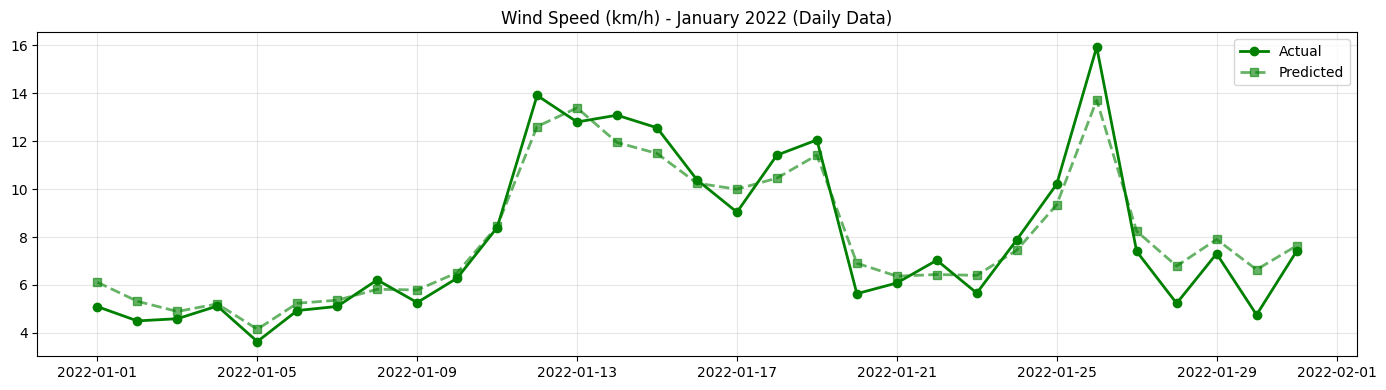


Wind Speed (km/h) Metrics:
  R-squared: 0.9251
  MAE: 0.7357
  MSE: 0.8064
  RMSE: 0.8980


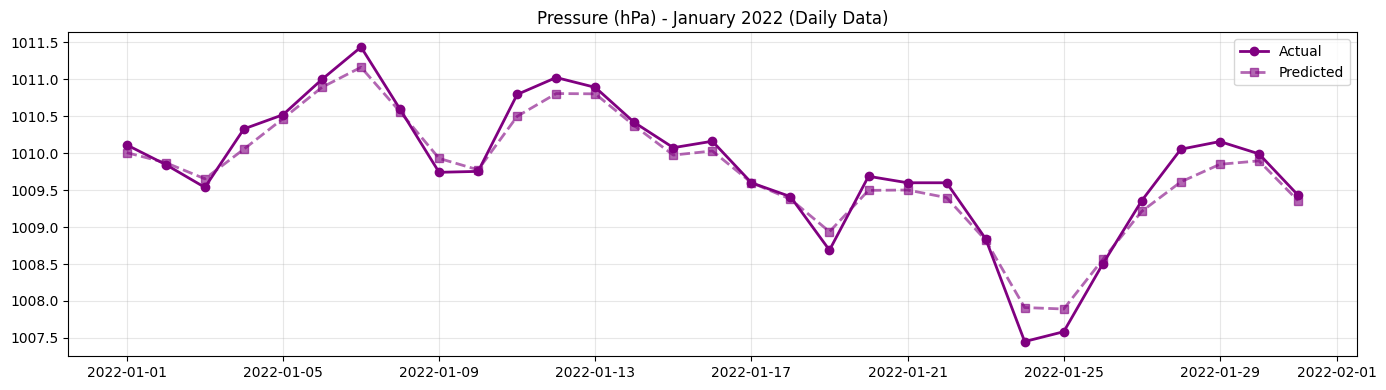


Pressure (hPa) Metrics:
  R-squared: 0.9528
  MAE: 0.1537
  MSE: 0.0382
  RMSE: 0.1956


In [305]:

jan_mask = (df_hourly['year'] == year) & (df_hourly['month'] == month)
df_jan = df_hourly[jan_mask].copy()

if len(df_jan) > 0:
    X_jan = df_jan[hourly_feature_cols]
    y_jan_pred = best_hourly_reg_model.fit(X_hourly_train, y_hourly_train_reg).predict(X_jan)
    df_jan['temp_pred'] = y_jan_pred[:, 0]
    df_jan['humidity_pred'] = y_jan_pred[:, 1]
    df_jan['windspeed_pred'] = y_jan_pred[:, 2]
    df_jan['pressure_pred'] = y_jan_pred[:, 3]

    df_jan_daily = df_jan.set_index('timestamp').resample('D').mean(numeric_only=True).reset_index()

    params = [('temp', 'temp_pred', 'Temperature (C)', 'red'),
              ('humidity', 'humidity_pred', 'Humidity (%)', 'blue'),
              ('windspeed', 'windspeed_pred', 'Wind Speed (km/h)', 'green'),
              ('sealevelpressure', 'pressure_pred', 'Pressure (hPa)', 'purple')]

    # os.makedirs('outputs', exist_ok=True)

    print("--- Regression Performance Evaluation (Daily Data) ---")
    for actual, pred, title, color in params:
        fig, ax = plt.subplots(figsize=(14, 4)) # Create a new figure for each parameter
        ax.plot(df_jan_daily['timestamp'], df_jan_daily[actual], '-o', color=color, label='Actual', linewidth=2)
        ax.plot(df_jan_daily['timestamp'], df_jan_daily[pred], '--s', color=color, alpha=0.6, label='Predicted', linewidth=2)
        ax.set_title(f'{title} - {month_map[month]} {year} (Daily Data)')
        ax.legend()
        ax.grid(True, alpha=0.3)

        plt.tight_layout()
        # plt.savefig(f'outputs/jan_2022_predictions_{actual}_v4.png', dpi=150)
        plt.show()

        # Performance Evaluation
        mae = mean_absolute_error(df_jan_daily[actual], df_jan_daily[pred])
        mse = mean_squared_error(df_jan_daily[actual], df_jan_daily[pred])
        rmse = np.sqrt(mse)
        r2 = r2_score(df_jan_daily[actual], df_jan_daily[pred])
        print(f"\n{title} Metrics:")
        print(f"  R-squared: {r2:.4f}")
        print(f"  MAE: {mae:.4f}")
        print(f"  MSE: {mse:.4f}")
        print(f"  RMSE: {rmse:.4f}")
else:
    print(f'No data for {month_map[month]} {year}')

### 6.3 Confusion Matrix

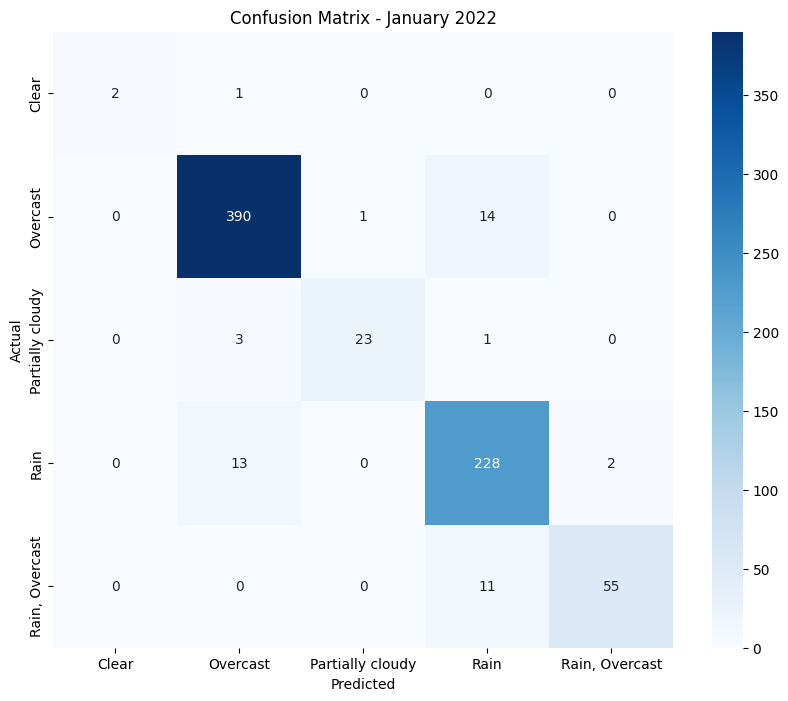

                  precision    recall  f1-score   support

           Clear       1.00      0.67      0.80         3
        Overcast       0.96      0.96      0.96       405
Partially cloudy       0.96      0.85      0.90        27
            Rain       0.90      0.94      0.92       243
  Rain, Overcast       0.96      0.83      0.89        66

        accuracy                           0.94       744
       macro avg       0.96      0.85      0.89       744
    weighted avg       0.94      0.94      0.94       744



In [306]:
if len(df_jan) > 0:
    y_jan_clf_pred = best_clf_model.predict(X_jan)
    cm = confusion_matrix(df_jan['conditions_encoded'], y_jan_clf_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=le_conditions.classes_, yticklabels=le_conditions.classes_)
    plt.title(f'Confusion Matrix - {month_map[month]} {year}')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()
    print(classification_report(df_jan['conditions_encoded'], y_jan_clf_pred, target_names=[str(c) for c in le_conditions.classes_]))